In [ ]:
# 시각자료에서 라벨 한글로 보여주기 -> 설치하고 런타임 재시작필요
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
# 기본 라이브러리 불러오기
import pandas as pd
import numpy as np
import os
import sys

# librosa 불러오기(파이썬 음성 분석 라이브러리) -> 음성벡터화 및 시각화 전문 라이브러리
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# 오디오파일 재생 라이브러리
from IPython.display import Audio

# 케라스 및 관련모듈 불러오기
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

# 경고메세지 숨기기
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# 감성대화 음성데이터 압축풀기 (구글드라이브 마운트활용)
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/감성대화/감성대화말뭉치(원천데이터)_음성데이터.zip"

In [16]:
#감성대화정보 엑셀로 불러오기
data_pre = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/감성대화/감성대화말뭉치_table.xlsx')

# 감정데이터중에 필요없는 카테고리('당황') 제거해주기

data_sub = data_pre.loc[(data_pre['감정_대분류'] == "기쁨") | (data_pre['감정_소분류'] == "안달하는") | (data_pre['감정_소분류'] == "성가신") | (data_pre['감정_소분류'] == "툴툴대는") | (data_pre['감정_소분류'] == "방어적인") | (data_pre['감정_소분류'] == "혐오스러운")
 | (data_pre['감정_소분류'] == "비통한") | (data_pre['감정_소분류'] == "슬픔") | (data_pre['감정_소분류'] == "우울한") | (data_pre['감정_소분류'] == "실망한") | (data_pre['감정_소분류'] == "후회되는") | (data_pre['감정_소분류'] == "눈물이 나는")
 | (data_pre['감정_소분류'] == "걱정스러운") | (data_pre['감정_소분류'] == "조심스러운") | (data_pre['감정_소분류'] == "초조한") | (data_pre['감정_소분류'] == "두려운") | (data_pre['감정_소분류'] == "스트레스 받는")
 | (data_pre['감정_소분류'] == "고립된") | (data_pre['감정_소분류'] == "염세적인") | (data_pre['감정_소분류'] == "상처") 
 ]
# 음성이 있고 및 라벨에 맞는 데이터 개수 확인하기
len(data_sub)



2428

In [ ]:
# 감정데이터 정수형(수치)로 바꿔주기 (정수 인코딩)
data_sub.loc[(data_sub['감정_소분류'] == "안달하는") | (data_sub['감정_소분류'] == "성가신") | (data_sub['감정_소분류'] == "툴툴대는") | (data_sub['감정_소분류'] == "방어적인") | (data_sub['감정_소분류'] == "혐오스러운"), 'Emotion'] = 1  #분노 => 1
data_sub.loc[(data_sub['감정_소분류'] == "비통한") | (data_sub['감정_소분류'] == "슬픔") | (data_sub['감정_소분류'] == "우울한") | (data_sub['감정_소분류'] == "실망한") | (data_sub['감정_소분류'] == "후회되는") | (data_sub['감정_소분류'] == "눈물이 나는"), 'Emotion'] = 2  #우울 => 2
data_sub.loc[(data_sub['감정_소분류'] == "걱정스러운") | (data_sub['감정_소분류'] == "조심스러운") | (data_sub['감정_소분류'] == "초조한") | (data_sub['감정_소분류'] == "두려운") | (data_sub['감정_소분류'] == "스트레스 받는"), 'Emotion'] = 3  #불안 => 3
data_sub.loc[(data_sub['감정_소분류'] == "고립된") | (data_sub['감정_소분류'] == "염세적인") | (data_sub['감정_소분류'] == "상처")  , 'Emotion'] = 4  #자살 => 4
data_sub[(data_sub['감정_대분류'] == "기쁨")]['Emotion'] = 0  #행복 => 5

data_sub


# 음성데이터 라벨 및 경로데이터만 뽑아오기
data_path = data.loc[:,['감정_대분류','감정_소분류','NO.']]
data_path.columns = ['Emotions','Path']

# 음성데이터 경로수정해주기(압축푼 폴더로 경로수정)
data_path['Path'] = '/content/emo_talk_source/'+data2['Path']+'.wav'

data_path.head(10)


# 음성데이터 라벨 및 경로데이터만 뽑아오기
data_path = data_sub.loc[:,['Emotion','NO.']]
data_path.columns = ['Emotions','Path']

# 음성데이터 경로수정해주기(압축푼 폴더로 경로수정)
data_path['Path'] = '/content/emo_talk_source/'+data_path['Path']+'.wav'

data_path.head(10)



In [60]:
# 감정데이터 정수형(수치)로 바꿔주기 (정수 인코딩)
data_sub = data_sub.copy()
data_sub.loc[(data_sub['감정_소분류'] == "안달하는") | (data_sub['감정_소분류'] == "성가신") | (data_sub['감정_소분류'] == "툴툴대는") | (data_sub['감정_소분류'] == "방어적인") | (data_sub['감정_소분류'] == "혐오스러운"), 'Emotion'] = '분노'  #분노
data_sub.loc[(data_sub['감정_소분류'] == "비통한") | (data_sub['감정_소분류'] == "슬픔") | (data_sub['감정_소분류'] == "우울한") | (data_sub['감정_소분류'] == "실망한") | (data_sub['감정_소분류'] == "후회되는") | (data_sub['감정_소분류'] == "눈물이 나는"), 'Emotion'] = '우울'  #우울 
data_sub.loc[(data_sub['감정_소분류'] == "걱정스러운") | (data_sub['감정_소분류'] == "조심스러운") | (data_sub['감정_소분류'] == "초조한") | (data_sub['감정_소분류'] == "두려운") | (data_sub['감정_소분류'] == "스트레스 받는"), 'Emotion'] = '불안'  #불안 
data_sub.loc[(data_sub['감정_소분류'] == "고립된") | (data_sub['감정_소분류'] == "염세적인") | (data_sub['감정_소분류'] == "상처")  , 'Emotion'] = '자살'  #자살 
data_sub.loc[(data_sub['감정_대분류'] == "기쁨"), 'Emotion'] = '기쁨' #기쁨


# 음성데이터 라벨 및 경로데이터만 뽑아오기
data_path = data_sub.loc[:,['Emotion','NO.']]
data_path.columns = ['Emotions','Path']

# 음성데이터 경로수정해주기(압축푼 폴더로 경로수정)
data_path['Path'] = '/content/emo_talk_source/'+data_path['Path']+'.wav'

data_path.head(10)


,Emotions,Path
84,기쁨,/content/emo_talk_source/M_000085.wav
85,기쁨,/content/emo_talk_source/M_000086.wav
86,기쁨,/content/emo_talk_source/M_000087.wav
87,기쁨,/content/emo_talk_source/M_000088.wav
88,기쁨,/content/emo_talk_source/M_000089.wav
89,기쁨,/content/emo_talk_source/M_000090.wav
90,기쁨,/content/emo_talk_source/M_000091.wav
91,기쁨,/content/emo_talk_source/M_000092.wav
92,기쁨,/content/emo_talk_source/M_000093.wav
93,기쁨,/content/emo_talk_source/M_000094.wav


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


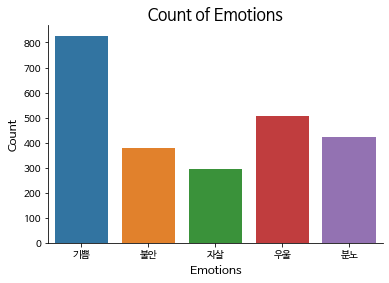

In [61]:
# 도표 및 그림에서 한글사용하기
plt.rc('font', family='NanumBarunGothic') 

# 감정의 전체적인 분포 확인하기
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [62]:
# 음성데이터를 waveplot, spectrogram 이미지로 표현

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft 함수는 음성을 시간기반에서 주파수기반으로 변환함
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


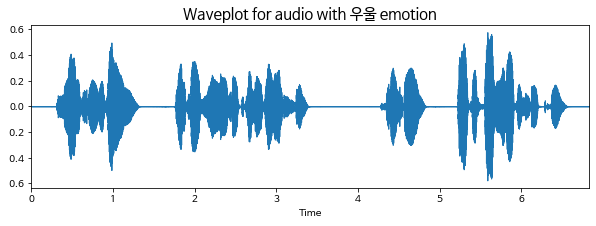

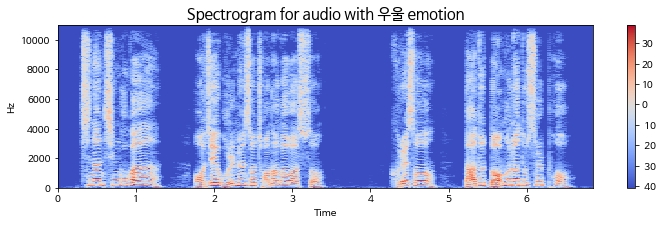

In [63]:
#슬픔 음성데이터 예시로 보기
emotion='우울'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


In [64]:
# 음성데이터 argumentation을 통해서 데이터 수 늘리기 및 오버피팅 방지
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# 예시
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

# 음성의 특성추출하는 함수 ( MFCC, MEL, RMSV)

def extract_features(data):

    result = np.array([])

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
#    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
#    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

# 음성의 특성을 추출한 데이터를 축적하는 함수 (Argumentation된 데이터도 같이)
def get_features(path):
    # duration과 offset은 각 오디오 파일의 시작과 끝에서 오디오가 없는 것을 처리
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # 원래데이터
    res1 = extract_features(data)
    result = np.array(res1)
    # 노이즈가 추가된 데이터
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # 병렬적으로 추가

    # 피칭및 스트레칭된 데이터
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # 병렬적으로 추가

    return result

In [65]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # 2개의 augmentation이 존재하므로 총 한개의 음성데이터가 3개의 음성데이터가 됨
        Y.append(emotion)
        

In [66]:
len(X), len(Y), data_path.Path.shape

(7284, 7284, (2428,))

In [67]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,labels
0,-273.432800,95.253670,-1.561941,17.696737,5.671216,-6.521183,1.086103,-2.507755,-12.285817,-5.190970,-12.275164,-8.838823,-2.639221,0.142257,-4.703226,1.303567,-13.498286,2.315273,-8.607200,-11.957307,0.027873,0.023279,0.119947,1.996975,7.265494,21.781948,33.756130,18.378857,3.282215,2.075486,2.728189,6.038461,11.239498,10.824953,16.623629,13.857752,7.076242,5.922993,15.744219,23.811867,...,0.046374,0.019254,0.008852,0.004059,0.002259,0.002918,0.003281,0.003415,0.003822,0.002620,0.003277,0.004165,0.004573,0.005797,0.006320,0.004307,0.005796,0.006958,0.007478,0.005889,0.002286,0.005637,0.006931,0.007463,0.010779,0.012479,0.013031,0.012443,0.013992,0.013199,0.009343,0.013318,0.017401,0.015757,0.013254,0.016252,0.009478,0.002350,0.000169,기쁨
1,-177.337045,49.729509,8.150989,10.280711,6.840087,-4.838624,-3.012127,-3.643086,-8.786069,-6.954912,-9.939335,-6.926915,-2.508390,-2.514063,-2.758620,-1.876562,-6.228778,-1.826141,-4.453613,-9.720884,0.033599,0.029854,0.124922,2.003283,7.317914,21.804664,33.670455,18.302099,3.292808,2.092632,2.740545,6.044638,11.230872,10.833773,16.619868,13.855059,7.093456,5.907903,15.813754,23.855540,...,0.050558,0.023228,0.013375,0.009584,0.007450,0.008781,0.009130,0.009828,0.009194,0.008355,0.008951,0.010571,0.010802,0.012354,0.012142,0.009915,0.011834,0.012853,0.012471,0.010450,0.007834,0.010896,0.012539,0.013863,0.017093,0.018584,0.018646,0.018848,0.019618,0.018864,0.015074,0.019134,0.022364,0.020735,0.019182,0.022143,0.015068,0.007752,0.005498,기쁨
2,-312.413239,90.988731,-5.592784,15.989615,2.854436,-9.070228,-0.880839,-5.755085,-14.288961,-6.204345,-15.047739,-6.130145,-0.086339,-2.095847,-4.320672,-2.463716,-11.267132,3.993315,-13.965066,-9.793280,0.010368,0.007762,0.016400,0.147839,0.876795,3.240626,8.864701,3.984981,1.034904,0.539309,0.353444,0.828676,1.844407,3.367063,1.938726,3.094397,1.900794,0.624463,0.961792,5.460216,...,0.020347,0.015364,0.006688,0.002456,0.001435,0.000613,0.000461,0.000872,0.000836,0.000795,0.000690,0.000586,0.000812,0.000971,0.001118,0.001531,0.001420,0.000995,0.001368,0.001349,0.001406,0.000757,0.000604,0.001751,0.001439,0.002461,0.002680,0.003138,0.002218,0.002350,0.002605,0.002539,0.002351,0.002812,0.003227,0.002774,0.002430,0.000871,0.000040,기쁨
3,-250.920578,86.833214,-7.769392,19.359568,-0.904133,-9.192878,-1.087429,-1.833798,-16.541750,-6.857524,-12.473576,-7.801505,-3.422049,-1.263897,-8.284364,3.624636,-14.034454,1.410524,-5.545053,-12.886340,0.018572,0.003834,0.098682,2.149852,8.598578,34.306343,33.115173,16.731546,18.375431,3.378729,2.207371,7.728913,15.534007,5.705993,3.054368,4.865041,30.168434,30.084047,22.722673,11.760110,...,0.087521,0.059349,0.033886,0.009450,0.014208,0.042461,0.035688,0.041568,0.031028,0.015296,0.020330,0.035438,0.024424,0.018798,0.023729,0.019926,0.017121,0.017045,0.016993,0.011967,0.006636,0.007908,0.006339,0.009168,0.008184,0.009784,0.010696,0.007915,0.009845,0.008309,0.006312,0.004954,0.005193,0.006085,0.004795,0.004128,0.002950,0.001023,0.000065,기쁨
4,-124.863139,36.512632,7.573724,9.283712,1.303459,-4.611863,-2.869603,-4.822518,-9.691965,-6.909598,-7.266093,-5.504048,-2.137672,-2.554603,-2.641405,-2.281804,-4.995875,-2.235578,-3.898278,-7.986853,0.042868,0.029953,0.125901,2.202159,8.638857,34.403913,33.286082,16.836198,18.562513,3.406338,2.256202,7.767005,15.679882,5.790526,3.066381,4.872143,30.204827,30.059025,22.807181,11.846008,...,0.113750,0.090648,0.063537,0.035494,0.040477,0.061817,0.056615,0.070091,0.057599,0.040812,0.047059,0.063620,0.049709,0.044009,0.050328,0.047648,0.045460,0.046254,0.043597,0.039272,0.036700,0.036891,0.033872,0.035520,0.034517,0.038292,0.039925,0.034250,0.036959,0.036877,0.032395,0.031244,0.033060,0.031167,0.032156,0.031257,0.029112

In [68]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [69]:
# 다중 클래스 분류하기위해 Y설정
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [70]:
# 훈련데이터, 테스트데이터 분리
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5463, 148), (5463, 5), (1821, 148), (1821, 5))

In [71]:
# 훈련 및 테스트데이터 갯수 확인
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5463, 148), (5463, 5), (1821, 148), (1821, 5))

In [72]:
# 데이터의 차원 모델에 맞게 통일 
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5463, 148, 1), (5463, 5), (1821, 148, 1), (1821, 5))

In [73]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(units=5, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 148, 256)          1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 74, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 74, 256)           327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 37, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 37, 128)           163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 128)           0

In [74]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.5, verbose=0, patience=3, min_lr=0.000005)
history=model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
86/86 [==============================] - 33s 32ms/step - loss: 1.5146 - accuracy: 0.3524 - val_loss: 1.4442 - val_accuracy: 0.3866
Epoch 2/100
86/86 [==============================] - 2s 19ms/step - loss: 1.4677 - accuracy: 0.3720 - val_loss: 1.4077 - val_accuracy: 0.4036
Epoch 3/100
86/86 [==============================] - 2s 19ms/step - loss: 1.4224 - accuracy: 0.3963 - val_loss: 1.4006 - val_accuracy: 0.4152
Epoch 4/100
86/86 [==============================] - 2s 21ms/step - loss: 1.3762 - accuracy: 0.4199 - val_loss: 1.3219 - val_accuracy: 0.4618
Epoch 5/100
86/86 [==============================] - 2s 20ms/step - loss: 1.3320 - accuracy: 0.4366 - val_loss: 1.2703 - val_accuracy: 0.4767
Epoch 6/100
86/86 [==============================] - 2s 19ms/step - loss: 1.3018 - accuracy: 0.4543 - val_loss: 1.2453 - val_accuracy: 0.4953
Epoch 7/100
86/86 [==============================] - 2s 20ms/step - loss: 1.2544 - accuracy: 0.4717 - val_loss: 1.1633 - val_accuracy: 0.5239
Epoch

57/57 [==============================] - 1s 7ms/step - loss: 1.5357 - accuracy: 0.7930
Accuracy of our model on test data :  79.29708957672119 %


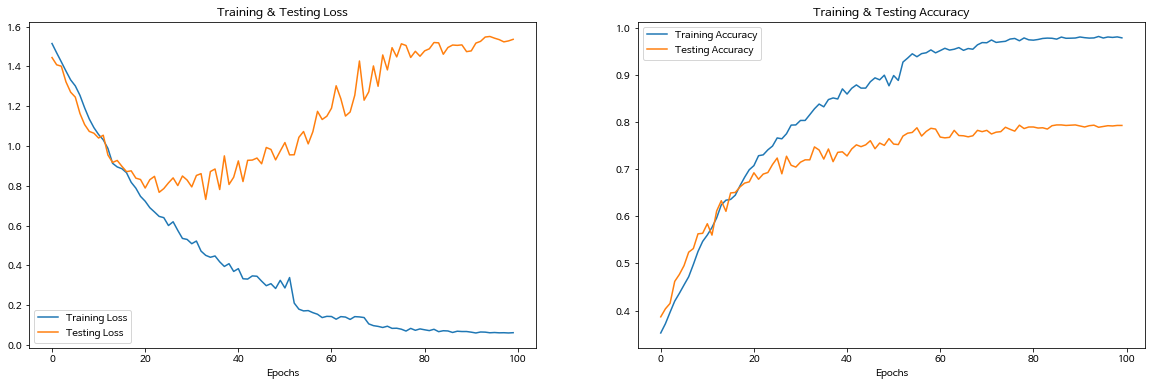

In [75]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [76]:
# 테스트데이터 적용
pred_test = model.predict(x_test)
pred_test
y_pred = encoder.inverse_transform(pred_test)
y_test2 = encoder.inverse_transform(y_test)

In [77]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test2

df.head(3)

,Predicted Labels,Actual Labels
0,기쁨,기쁨
1,분노,기쁨
2,자살,자살


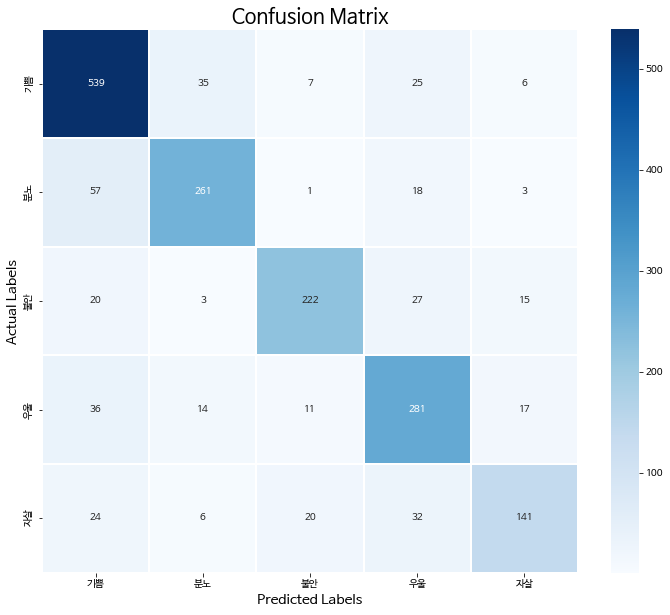

In [78]:
cm = confusion_matrix(y_test2, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [79]:
print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

          기쁨       0.80      0.88      0.84       612
          분노       0.82      0.77      0.79       340
          불안       0.85      0.77      0.81       287
          우울       0.73      0.78      0.76       359
          자살       0.77      0.63      0.70       223

    accuracy                           0.79      1821
   macro avg       0.79      0.77      0.78      1821
weighted avg       0.79      0.79      0.79      1821

